In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
import math
from typing import Counter
import copy
import random
data = np.load("C:\\Users\\baljyot\\Downloads\\mnist.npz")
x_train=data['x_train']
y_train=data['y_train']
x_test=data['x_test']
y_test=data['y_test']
indices = np.where((y_train == 0) | (y_train == 1) | (y_train == 2))[0]
x_train = x_train[indices]
y_train = y_train[indices]
indices = np.where((y_test == 0) | (y_test == 1) | (y_test == 2))[0]
x_test = x_test[indices]
y_test = y_test[indices]


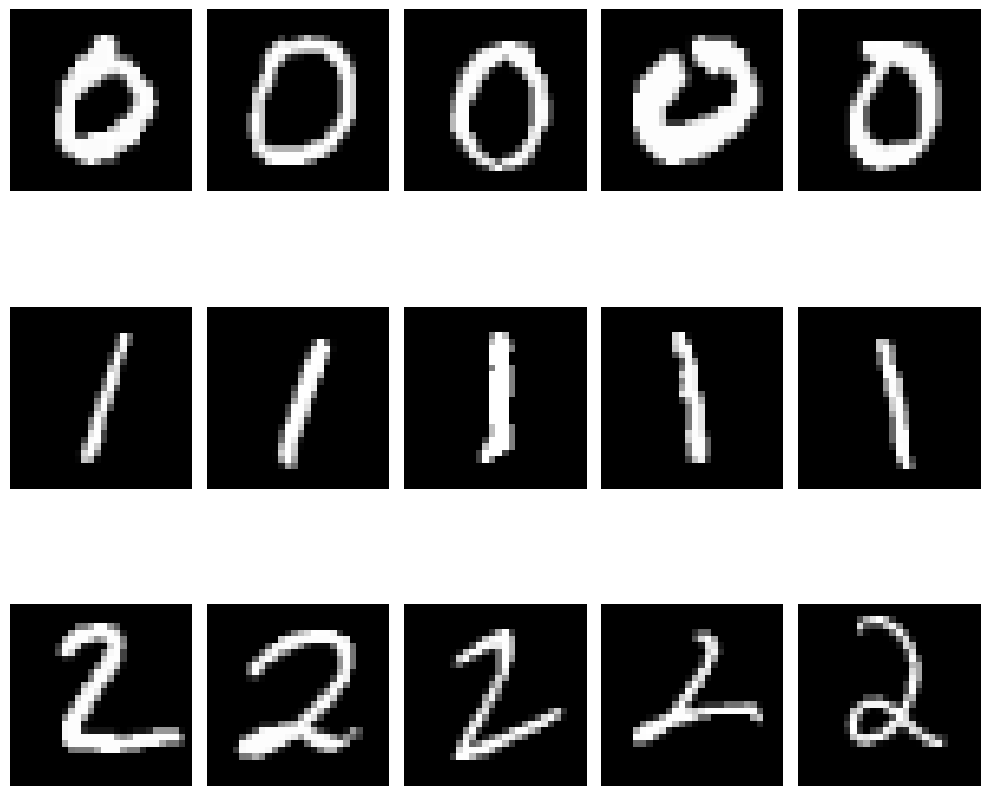

In [2]:
fig, axes = plt.subplots(3, 5, figsize=(10, 10))
axes = axes.flatten()
for k in range(3):
    index = np.where(y_test == k)[0]
    for i in range(5):
        ax = axes[k * 5 + i]
        ax.imshow(x_test[index[i]], cmap='gray')
        ax.axis('off')

plt.tight_layout()
plt.show()

In [3]:
flattened=[]
for i in range(len(x_train)):
    flattened.append(x_train[i].flatten())
x_train=np.array(flattened)
flattened=[]
for i in range(len(x_test)):
    flattened.append(x_test[i].flatten())
x_test=np.array(flattened)
x_train=np.transpose(x_train)
sums=[]
centralisedMean=np.mean(x_train,axis=1)
centralisedData=[]
for i in range(x_train.shape[0]):
    l=[]
    for j in range(x_train.shape[1]):
        l.append(x_train[i][j]- centralisedMean[i])
    centralisedData.append(l)
centralisedMean=np.array(np.mean(centralisedData,axis=1))

S=np.matmul( centralisedData ,np.transpose(centralisedData))/18622

eigenvalues, eigenvectors = np.linalg.eigh(S)
eigenvalues = eigenvalues[::-1]
U = np.flip(eigenvectors, axis=1)

nUp=U[:,:10]
x_proj=np.matmul(nUp.T,x_train-x_train.mean(axis=1)[:,np.newaxis])
# print(x_proj[:100])
x_test.shape
x_test=np.transpose(x_test)
x_proj_test=np.matmul(nUp.T,x_test-x_train.mean(axis=1)[:,np.newaxis])


In [40]:
class Node:
    def __init__(self):
        self.left = None
        self.right = None
        self.p = None
        self.wG_r=None
        self.wG_l=None
        self.leaf_value=None
        self.threshold=None
class Region:
    def __init__(self):
        self.one=0
        self.two=0
        self.zero=0
        self.total=0
        self.gini=0
    def add_value(self, input_value):
        self.total+=1
        if input_value == 1:
            self.one += 1
        elif input_value == 2:
            self.two += 1
        elif input_value == 0:
            self.zero += 1
    def calc_gini_index(self):
        if (self.total==0): return 0
        
        p1=self.one/self.total
        p2=self.two/self.total
        p3=self.zero/self.total

        self.gini=p1*(1-p1)+p2*(1-p2)+p3*(1-p3)

        return self.gini
    def predict(self):
        if (self.one > self.two and self.one >self.zero):
            return 1
        if (self.two > self.one and self.two >self.zero):
            return 2
        if (self.zero > self.two and self.zero >self.one):
            return 0
    def print(self):
        print("0 : ",self.zero)
        print("1 : ",self.one)

        print("2 : ",self.two)




In [41]:

def get_best_split(dataset,y_test):
    best_split_gini=-2
    best_split={}
    for p in range(10):
        threshold=np.mean(dataset[p])
        left_region=Region()
        right_region=Region()
        for i in range(len(dataset[p])):
            if (dataset[p][i]<=threshold):
                left_region.add_value(y_test[i])
            else:
                right_region.add_value(y_test[i])
        w_l=left_region.total/(left_region.total+right_region.total)
        w_r=1-w_l
        G_l=left_region.calc_gini_index()
        G_r=right_region.calc_gini_index()
        curr_gini=w_l*G_l+w_r*G_r
        if (best_split_gini==-2 or curr_gini<best_split_gini):
            best_split['wg_l']=w_l*G_l
            best_split['wg_r']=w_r*G_r
            best_split['p']=p
            best_split['threshold']=threshold
            column_p = dataset[p]
            indices_l = np.where(column_p <= threshold)[0]
            indices_r=np.where(column_p > threshold)[0]
            best_split['left_data']=dataset[:, indices_l]
            best_split['left_data_train']=y_test[indices_l]
            best_split['right_data']=dataset[: , indices_r]
            best_split['right_data_train']=y_test[indices_r]

            best_split['left_region']=copy.deepcopy(left_region)
            best_split['right_region']=copy.deepcopy(right_region)
            best_split_gini=curr_gini

    
    return best_split

In [42]:
def build_tree(dataset, num_leaf_nodes,y_train):
    # dataset.shape=10 * (num of datapoints)
    root = Node()
    curr=root
    curr_dataset=dataset
    curr_y_train=y_train
    cuts=[]
    for i in range(1,num_leaf_nodes):
        best_split=get_best_split(curr_dataset,curr_y_train)
        curr.p=best_split['p']
        
        curr.threshold=best_split['threshold']
        cuts.append([curr.p,curr.threshold])
        random_region = random.choice([0, 1])# 1: left_region -leaf 0: vice-versa
        if(i==num_leaf_nodes-1):
            left=Node()
            right=Node()
            left.leaf_value=best_split['left_region'].predict()
            right.leaf_value=best_split['right_region'].predict()
            curr.left=left
            curr.right=right

        # elif (best_split['wg_l']<=best_split['wg_r']):
        elif (random_region):
            left=Node()
            left.leaf_value=best_split['left_region'].predict()
            right=Node()
            curr_dataset=best_split['right_data']
            curr_y_train=best_split['right_data_train']
            curr.left=left
            curr.right=right
            curr=right

        else:
            right=Node()
            right.leaf_value=best_split['right_region'].predict()
            left=Node()
            curr_dataset=best_split['left_data']
            curr_y_train=best_split['left_data_train']
            curr.left=left
            curr.right=right
            curr=left
    return root,cuts

        

In [43]:
def prediction(root,point):
    # point = 1*10
    while(True):
        if(root.leaf_value!=None):
            return root.leaf_value
        else:
            if (point[root.p]<=root.threshold):
                root=root.left
            else:
                root=root.right
def accuracy(root, X,Y):
    # x=10 * 18623
    X=X.T
    acurracies=[[0,0] for i in range(3) ]
    for i in range(X.shape[0]):
        acurracies[Y[i]][1]+=1
        if Y[i]==prediction(root, X[i]):
            acurracies[Y[i]][0]+=1
    return acurracies


In [44]:
root,cuts=build_tree(x_proj, 3, y_train)
acc=accuracy(root, x_proj_test,y_test)
print(cuts)
tot=0
cnt=0
for i in acc:
    tot+=((i[0]/i[1])*100)
    print(cnt,":",(i[0]/i[1])*100,"%")
    cnt+=1
print("Total Accuracy",tot/3,"%")

[[0, 2.6372074260719605e-13], [0, -704.9124522176124]]
0 : 99.08163265306122 %
1 : 90.30837004405286 %
2 : 53.29457364341085 %
Total Accuracy 80.89485878017497 %


In [45]:
store=x_train
s_train=x_test

In [46]:
# new_x_train=x_proj.T
bags=[]
trees=[]
num_bags=5
cuts=[]
x_train=x_train.T
# x_test=x_test.T
for i in range(num_bags):
    indices = np.random.choice(np.arange(x_train.shape[0]), x_train.shape[0], replace=True)    
    D=x_train[indices].T
    sums=[]
    centralisedMean=np.mean(D,axis=1)
    centralisedData=[]
    for i in range(D.shape[0]):
        l=[]
        for j in range(D.shape[1]):
            l.append(D[i][j]- centralisedMean[i])
        centralisedData.append(l)
    centralisedMean=np.array(np.mean(centralisedData,axis=1))
    # print(centralisedMean)

    S=np.matmul( centralisedData ,np.transpose(centralisedData))/18622

    eigenvalues, eigenvectors = np.linalg.eigh(S)
    eigenvalues = eigenvalues[::-1]
    U = np.flip(eigenvectors, axis=1)

    nUp=U[:,:10]
    # print(nUp)

    x_proj=np.matmul(nUp.T,D-D.mean(axis=1)[:,np.newaxis])
    # print(x_proj[:100])

    x_proj_test=np.matmul(nUp.T,x_test-D.mean(axis=1)[:,np.newaxis])
    # print(x_proj_test[:100])
    Y=y_train[indices]
  
    bags.append([D.T,Y])
    t,cut=build_tree(x_proj,3,Y)
    cuts.append(cuts)
    print(cut)
    trees.append([t,x_proj_test])
print(len(trees))

[[0, -1.6702313698455753e-13], [1, -41.34496373006039]]
[[0, -1.4309292145168231e-13], [0, 702.9038841891943]]
[[0, 7.423250532647001e-14], [1, -31.70382155418167]]
[[0, 1.910510268665465e-13], [0, -703.5270197155132]]
[[0, 2.488742415419021e-13], [0, -700.1418423796711]]
5


In [47]:
def majority_voting(predictions):
    class_counts = Counter(predictions)
    majority_class, majority_count = class_counts.most_common(1)[0]    
    return majority_class
 

In [48]:

dataset=x_proj_test
dataset=dataset.T
accuracies=[[0,0] for i in range(3) ]
for i in range(dataset.shape[0]):
    accuracies[y_test[i]][1]+=1
    predictions = []  
    for j in range(num_bags):
        p=prediction(trees[j][0],trees[j][1].T[i])
        predictions.append(p)    
    final_prediction = majority_voting(predictions)

    
    if y_test[i] == final_prediction:
        accuracies[y_test[i]][0] += 1

acc=accuracies
tot=0
cnt=0
for i in acc:
    tot+=((i[0]/i[1])*100)
    print(cnt,":",(i[0]/i[1])*100,"%")
    cnt+=1
print("Total Accuracy",tot/3,"%")

0 : 98.9795918367347 %
1 : 91.18942731277532 %
2 : 54.166666666666664 %
Total Accuracy 81.44522860539222 %
